# Sensitivity of the subbasin size on discharge

This example shows how to change the subbasin size repeatedly using the builtin GRASS interface and investigate the changes in discharge of each configuration. 

In [1]:
# hidden cell to setup
import swimpy, os
%matplotlib inline

project_path = os.path.join(os.path.dirname(swimpy.__file__), '../tests/project')
os.chdir(project_path)
if not os.path.exists('swimpy'):
    p = swimpy.project.setup()
    p.browser.settings.unset()

In [4]:
import os
import pandas as pd
from matplotlib import pyplot as plt

import swimpy

grass_settings = dict(grass_db='../../tests/grassdb',
                      grass_location='utm32n',
                      grass_mapset='swim',
                      grass_setup=dict(elevation="elevation@PERMANENT",
                                       stations="stations@PERMANENT",
                                       landuse="landuse@PERMANENT",
                                       soil="soil@PERMANENT",
                                       upthresh=40,
                                       lothresh=11)
                     )

p = swimpy.Project()

# work on a clone to avoid messing things up
c = p.clone('subbasin_size_sensitivity', **grass_settings)

# r.watershed threshold values
upthresh = [20, 50, 200]
# get clim file averages
mclim = c.climate.inputdata.mean(axis=1, level=0)

q = pd.DataFrame()
for ut in upthresh:
    # run m.swim.subbasins and necessary postprocesses
    c.subbasins.update(upthresh=ut)
    # get mean subbasin size and count
    sb_size = c.subbasins.attributes['size']
    nsb = len(sb_size)
    # put mean values and right number of subbasins into clim files
    nclim = pd.DataFrame({(v, i+1): mclim[v] for v in mclim.columns for i in range(nsb)})
    c.climate.inputdata(nclim)
    # run SWIM
    c.run(save=False, quiet=True)
    # keep Q at Blankenstein
    label = '%1.1f (n=%i)' % (sb_size.mean(), nsb)
    q[label] = c.station_daily_discharge['BLANKENSTEIN']
    print('Upthresh %s -> mean subbasin size %s' % (ut, label))


Upthresh 20 -> mean subbasin size 48.2 (n=21)
Upthresh 50 -> mean subbasin size 126.5 (n=8)
Upthresh 200 -> mean subbasin size 337.4 (n=3)


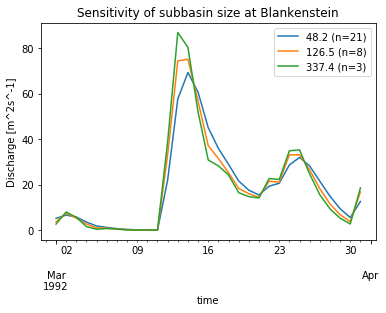

In [8]:
# visualise results
ax = q['1992-03-01':'1992-03-31'].plot()
plt.title('Sensitivity of subbasin size at Blankenstein')
yl = plt.ylabel('Discharge [m^2s^-1]')  